In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, classification_report

**Veriyi içeriye aktardık**

In [11]:
data = pd.read_csv("C:/Users/MehmetSalih/Desktop/creditcard.csv")

df = data.copy()

**Veri ön işleme kısmında aykırı sütunlar olan time ve amount için ölçeklendirme yapıyoruz. Sonraki adımda ise test ve eğitim verimizi ayırıyoruz.Bu kısım eğitimimiz doğrulamanması açısından önemli.**

In [12]:

scaler = RobustScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))


df.drop(['Time', 'Amount'], axis=1, inplace=True)


X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Eğitim Seti Boyutu: {X_train.shape}")
print(f"Test Seti Boyutu: {X_test.shape}")

Eğitim Seti Boyutu: (227845, 30)
Test Seti Boyutu: (56962, 30)


**Sınıf ağırlıkları sayesinde azınlık sınıfında yer alan dolandırıcılık işlemlerlini model görmezden gelmesini engellemiş oluyoruz**

In [13]:
neg, pos = np.bincount(df['Class'])
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"\nModel için Sınıf Ağırlıkları -> Normal: {weight_for_0:.2f}, Fraud: {weight_for_1:.2f}")


Model için Sınıf Ağırlıkları -> Normal: 0.50, Fraud: 289.44


**Dengesiz veri setinden dolayı doğruluk oranına bakmak yanıltıcı olabilir bu yüzden bazı metrikler tanımlayarak modelin doğruluğunu hesaplayacağız. 3 katmanlı bu sistem giriş, gizli ve çıkış katmanlarında oluşuyor.Gizli sinir ağı katmanı relu yani azaltılmış lineer sistem ile modelleniyor çıkış ise sigmoid sistem ile modellenerek sonucu 0 veya 1 şeklinde binary sınıflandırma yapıyor.Dropout katmanları sayesinde eğitim sırasında nöronların bir kısmını devre dışı bırakarak overfitting (aşırı öğrenme)'nin önüne geçmeyi engelliyor.Model eğitim sırasında Adam optimizasyon algoritmasını kullanıyor.Aynı zamanda binary crossentropy ile sınıflandırma başarısını ölçüyor.Hiperparametre optimizasyonu için ise 3 farklı model belirleyerek hangi modelin daha yüksek başarımda çalıştığını gözlemledim.**

In [39]:
METRICS = [
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

model = keras.Sequential([
    
    keras.Input(shape=(X_train.shape[-1],)),
    
    
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.45),
    
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.45),
    
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=METRICS
)

model2 = keras.Sequential([
    keras.Input(shape=(X_train.shape[-1],)),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])

model2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2), 
               loss='binary_crossentropy', metrics=METRICS)

model3 = keras.Sequential([
    keras.Input(shape=(X_train.shape[-1],)),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

model3.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
               loss='binary_crossentropy', metrics=METRICS)



**Kalan adımlarda erken bitirme adımlarıyla eğitimi 10 tur boyunca iyileşemediğini anladığında eğitimi durdurarak aşırı öğrenmeyi önlüyor ve elde edilen ağırlıkların koruyor**

In [40]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)
models = [model, model2, model3]
histories = []

for i, m in enumerate(models):
    print(f"Model {i+1} Eğitimi Başlıyor")
    
    history = m.fit(
        X_train, y_train,
        batch_size=2048,           
        epochs=100,                
        callbacks=[early_stopping],
        validation_data=(X_test, y_test),
        class_weight=class_weight, 
        verbose=1
    )
    histories.append(history)
    print(f"Model {i+1} eğitimi tamamlandı.")


Model 1 Eğitimi Başlıyor
Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - auc: 0.5824 - fn: 185.0000 - fp: 82559.0000 - loss: 1.3047 - precision: 0.0025 - recall: 0.5305 - tn: 144892.0000 - tp: 209.0000 - val_auc: 0.9480 - val_fn: 9.0000 - val_fp: 13140.0000 - val_loss: 0.5438 - val_precision: 0.0067 - val_recall: 0.9082 - val_tn: 43724.0000 - val_tp: 89.0000
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7743 - fn: 101.0000 - fp: 75544.0000 - loss: 0.6439 - precision: 0.0039 - recall: 0.7437 - tn: 151907.0000 - tp: 293.0000 - val_auc: 0.9654 - val_fn: 7.0000 - val_fp: 8084.0000 - val_loss: 0.4594 - val_precision: 0.0111 - val_recall: 0.9286 - val_tn: 48780.0000 - val_tp: 91.0000
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8518 - fn: 90.0000 - fp: 51380.0000 - loss: 0.5131 - precision: 0.0059 - recall: 0.7716 - tn: 176071.0000 - tp: 304.0000 - val_auc: 0.9685 - val_fn: 9.0000 - val_fp: 3557.0000 - val_loss: 0.3402 - val_precision: 0.0244 - val_rec


Model 1 ANALİZİ
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step

[Model 1] Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.91      0.13        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962



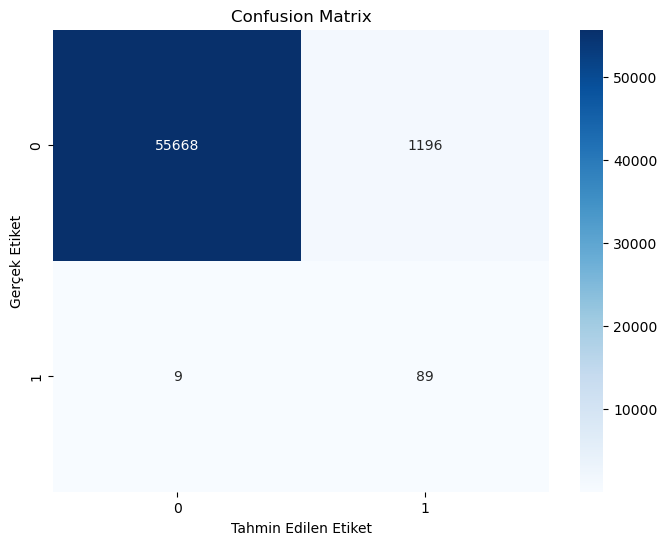

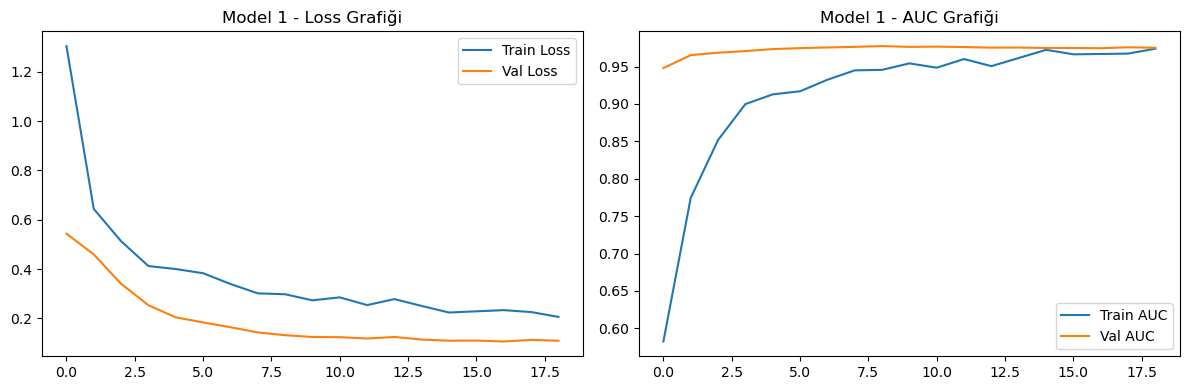


Model 2 ANALİZİ
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step

[Model 2] Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.91      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962



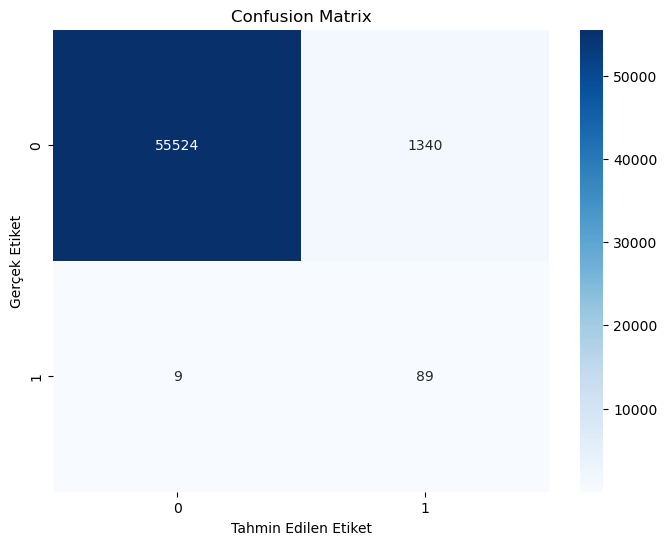

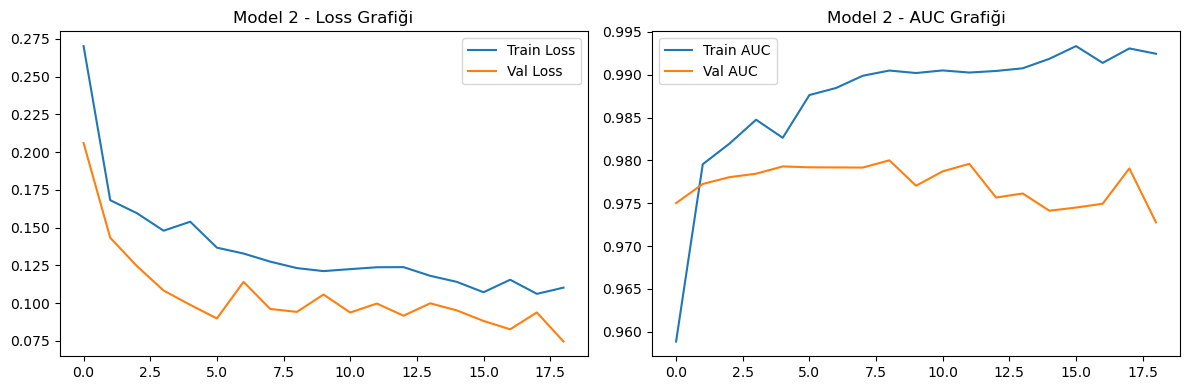


Model 3 ANALİZİ
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step

[Model 3] Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     56864
           1       0.00      0.26      0.00        98

    accuracy                           0.83     56962
   macro avg       0.50      0.54      0.45     56962
weighted avg       1.00      0.83      0.90     56962



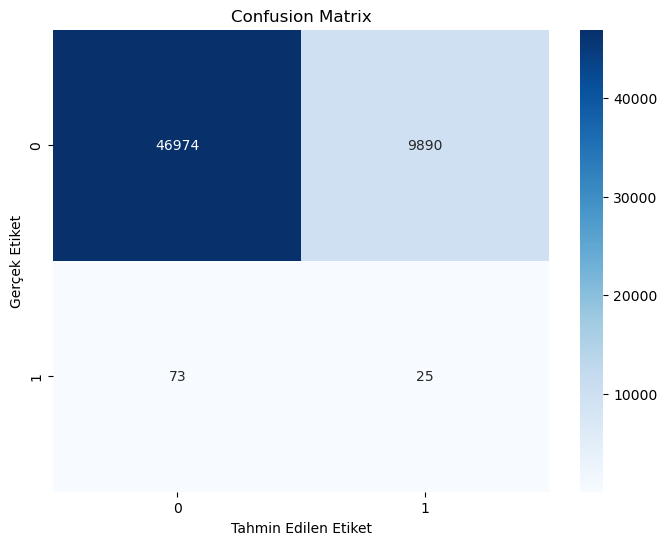

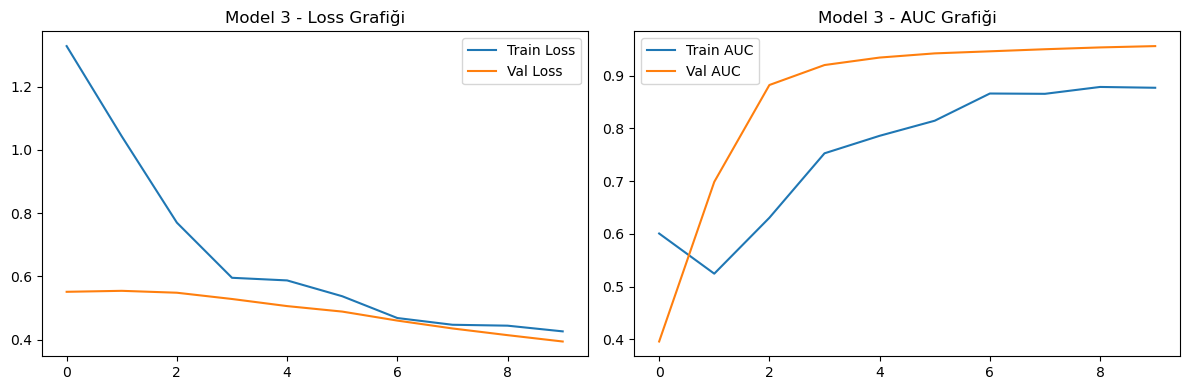

In [41]:

for i, (m, h) in enumerate(zip(models, histories)):
    model_name = f"Model {i+1}"
    print(f"\n{'='*30}\n{model_name} ANALİZİ\n{'='*30}")
    
    y_pred_probs = m.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int) 

    print(f"\n[{model_name}] Detaylı Sınıflandırma Raporu:")
    print(classification_report(y_test, y_pred))

   
    plot_confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(12, 4))
    
 
    plt.subplot(1, 2, 1)
    plt.plot(h.history['loss'], label='Train Loss')
    plt.plot(h.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss Grafiği')
    plt.legend()

   
    plt.subplot(1, 2, 2)
    plt.plot(h.history['auc'], label='Train AUC')
    plt.plot(h.history['val_auc'], label='Val AUC')
    plt.title(f'{model_name} - AUC Grafiği')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [42]:
from sklearn.metrics import confusion_matrix

for i, m in enumerate(models):
    print(f"\n{'='*45}")
    print(f"MODEL {i+1} PERFORMANS ÖZETİ")
    print(f"{'='*45}")

    y_pred_probs = m.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    print(f"True Negatives  (TN - Doğru Normal) : {tn}")
    print(f"False Positives (FP - Yanlış Alarm) : {fp}")
    print(f"False Negatives (FN - Kaçan Fraud)  : {fn}")
    print(f"True Positives  (TP - Yakalanan)    : {tp}")

    recall_score = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    print(f"\nModel {i+1} Yakalama Oranı (Recall): %{recall_score:.2f}")


MODEL 1 PERFORMANS ÖZETİ
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 599us/step
True Negatives  (TN - Doğru Normal) : 55668
False Positives (FP - Yanlış Alarm) : 1196
False Negatives (FN - Kaçan Fraud)  : 9
True Positives  (TP - Yakalanan)    : 89

Model 1 Yakalama Oranı (Recall): %90.82

MODEL 2 PERFORMANS ÖZETİ
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 613us/step
True Negatives  (TN - Doğru Normal) : 55524
False Positives (FP - Yanlış Alarm) : 1340
False Negatives (FN - Kaçan Fraud)  : 9
True Positives  (TP - Yakalanan)    : 89

Model 2 Yakalama Oranı (Recall): %90.82

MODEL 3 PERFORMANS ÖZETİ
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step
True Negatives  (TN - Doğru Normal) : 46974
False Positives (FP - Yanlış Alarm) : 9890
False Negatives (FN - Kaçan Fraud)  : 73
True Positives  (TP - Yakalanan)    : 25

Model 3 Yakalama Oranı (Recall): %25.51


**3 modelin çıktılarını incelediğimizde az ve orta yoğunlukta katmanlara sahip olan modeller daha başarılı olurken daha yoğun katmanlara sahip olan model aşırı öğrenme nedeniyle doğruluk oranında sınıfta kaldı. Bu nedenle veriseti özelinde kullanacağımız model orta yoğunluktaki model olacaktır.**